### Load Packages

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
img = iio.imread("COVID-19_Lung_CT_Scans/COVID-19/COVID-19_0001.png")

/var/folders/lk/hyjh65cs031b72f7011pqk4c0000gn/T/ipykernel_17658/2422092446.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = iio.imread("COVID-19_Lung_CT_Scans/COVID-19/COVID-19_0001.png")


In [11]:
img.max(), img.min()

(255, 0)

### Load Data

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

In [16]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [18]:
trainset.data.shape

(50000, 32, 32, 3)

In [19]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [20]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [21]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [22]:
def imshow(img):
    img = img / 2 + 0.5 # Unnormalize the data
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

torch.Size([4, 3, 32, 32])


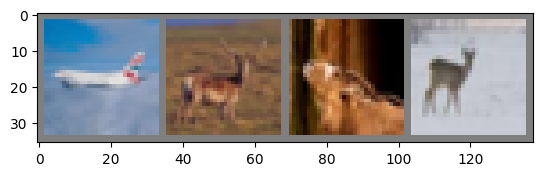

plane deer  deer  deer 


In [23]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Train Model

The forward pass returns both the prediction and the embeddings (120 long vector) from after the first fcl. These embeddings are used to train a KNN model.

In [12]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    embedding = x.clone()
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x, embedding

net = Net()

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)#, momentum=0.9)
num_epochs = 40
train_loss = []

In [14]:
for epoch in range(num_epochs):
    running_loss = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs, embeddings = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    train_loss.append(epoch_loss / 12500)

print('Finished Training')

[1,  2000] loss: 1.871
[1,  4000] loss: 1.592
[1,  6000] loss: 1.489
[1,  8000] loss: 1.462
[1, 10000] loss: 1.407
[1, 12000] loss: 1.386
[2,  2000] loss: 1.315
[2,  4000] loss: 1.299
[2,  6000] loss: 1.297
[2,  8000] loss: 1.275
[2, 10000] loss: 1.255
[2, 12000] loss: 1.241
[3,  2000] loss: 1.168
[3,  4000] loss: 1.191
[3,  6000] loss: 1.166
[3,  8000] loss: 1.172
[3, 10000] loss: 1.191
[3, 12000] loss: 1.159
[4,  2000] loss: 1.086
[4,  4000] loss: 1.118
[4,  6000] loss: 1.124
[4,  8000] loss: 1.134
[4, 10000] loss: 1.100
[4, 12000] loss: 1.113
[5,  2000] loss: 1.043
[5,  4000] loss: 1.045
[5,  6000] loss: 1.063
[5,  8000] loss: 1.061
[5, 10000] loss: 1.085
[5, 12000] loss: 1.069
[6,  2000] loss: 1.005
[6,  4000] loss: 1.030
[6,  6000] loss: 1.013
[6,  8000] loss: 1.018
[6, 10000] loss: 1.037
[6, 12000] loss: 1.039
[7,  2000] loss: 0.971
[7,  4000] loss: 0.973
[7,  6000] loss: 0.997
[7,  8000] loss: 0.983
[7, 10000] loss: 1.001
[7, 12000] loss: 1.009
[8,  2000] loss: 0.931
[8,  4000] 

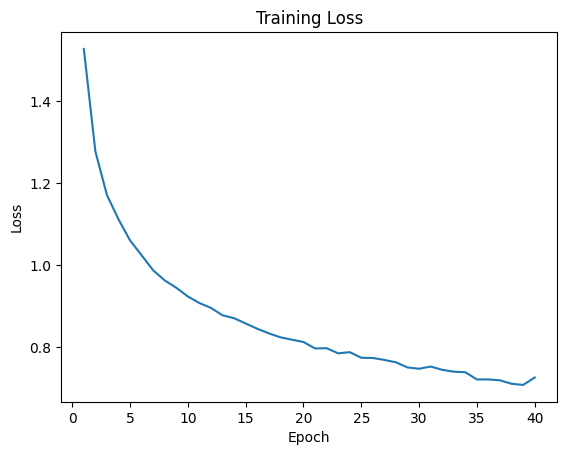

In [15]:
epochs = range(1, num_epochs + 1)

plt.plot(epochs, train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

### Save Model and Train Embeddings

In [18]:
PATH = './cifar_net_adam.pth'
torch.save(net.state_dict(), PATH)

In [28]:
## Loading Different Model
PATH = './cifar_net.pth'

In [29]:
net = Net()
net.load_state_dict(torch.load(PATH))

all_embeddings = []
all_labels = []

with torch.no_grad():
  for images, labels in trainloader:
    pred, embeddings = net(images)
    all_embeddings.append(embeddings.numpy())
    all_labels.append(labels.numpy())

In [30]:
all_embeddings = np.concatenate(all_embeddings, axis=0)
embeddings = pd.DataFrame(data=all_embeddings)
embeddings

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,7.495938,0.0,0.0,0.00000,0.000000,0.00000,0.0,0.0,3.509861,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,7.430928,0.000000,6.736554
1,0.000000,0.0,0.0,0.00000,2.057728,0.00000,0.0,0.0,4.955121,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.624170,0.000000,0.596815
2,0.000000,0.0,0.0,5.67433,0.000000,0.00000,0.0,0.0,2.471318,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,5.764756,0.000000
3,20.206598,0.0,0.0,0.00000,25.439716,0.00000,0.0,0.0,0.000000,0.000000,...,21.365650,0.000000,0.000000,0.000000,0.000000,0.0,42.339977,0.000000,0.000000,34.024960
4,6.862210,0.0,0.0,0.00000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,17.532112,0.000000,0.000000,0.0,0.000000,8.997573,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.000000,0.0,0.0,0.00000,0.000000,0.00000,0.0,0.0,0.000000,17.864109,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
49996,1.223633,0.0,0.0,0.00000,13.573211,0.00000,0.0,0.0,4.613994,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
49997,0.000000,0.0,0.0,0.00000,0.000000,5.27631,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,3.960019,0.000000
49998,0.000000,0.0,0.0,0.00000,0.000000,11.31659,0.0,0.0,3.090648,0.000000,...,15.011663,0.000000,0.000000,12.332265,3.914943,0.0,0.000000,0.000000,0.000000,0.000000


In [31]:
all_labels = np.concatenate(all_labels, axis=0)
embeddings['label'] = all_labels
embeddings

train_embeddings = embeddings
train_embeddings

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,label
0,7.495938,0.0,0.0,0.00000,0.000000,0.00000,0.0,0.0,3.509861,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,7.430928,0.000000,6.736554,9
1,0.000000,0.0,0.0,0.00000,2.057728,0.00000,0.0,0.0,4.955121,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.624170,0.000000,0.596815,5
2,0.000000,0.0,0.0,5.67433,0.000000,0.00000,0.0,0.0,2.471318,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,5.764756,0.000000,2
3,20.206598,0.0,0.0,0.00000,25.439716,0.00000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,42.339977,0.000000,0.000000,34.024960,6
4,6.862210,0.0,0.0,0.00000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,...,0.000000,17.532112,0.000000,0.000000,0.0,0.000000,8.997573,0.000000,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.000000,0.0,0.0,0.00000,0.000000,0.00000,0.0,0.0,0.000000,17.864109,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,6
49996,1.223633,0.0,0.0,0.00000,13.573211,0.00000,0.0,0.0,4.613994,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,8
49997,0.000000,0.0,0.0,0.00000,0.000000,5.27631,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,3.960019,0.000000,8
49998,0.000000,0.0,0.0,0.00000,0.000000,11.31659,0.0,0.0,3.090648,0.000000,...,0.000000,0.000000,12.332265,3.914943,0.0,0.000000,0.000000,0.000000,0.000000,8


### Test Model

This is testing the model purely using the CNN.

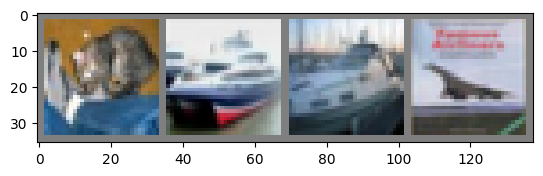

GroundTruth: cat   ship  ship  plane


In [32]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [33]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [34]:
outputs, embeddings = net(images)

In [35]:
_, predicted = torch.max(outputs, 1)
print('Predicted:', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted: cat   plane plane ship 


In [36]:
correct = 0
total = 0

all_embeddings = []
all_labels = []

with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs, embeddings = net(images)

    all_embeddings.append(embeddings.numpy())
    all_labels.append(labels.numpy())

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on 10000 test images: {100 * correct // total} %')

Accuracy of the network on 10000 test images: 58 %


In [37]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs, embeddings = net(images)
    _, predictions = torch.max(outputs, 1)

    for label, prediction in zip(labels, predictions):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
  accuracy = 100 * float(correct_count) / total_pred[classname]
  print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 67.3 %
Accuracy for class: car   is 70.4 %
Accuracy for class: bird  is 49.3 %
Accuracy for class: cat   is 40.9 %
Accuracy for class: deer  is 48.7 %
Accuracy for class: dog   is 48.5 %
Accuracy for class: frog  is 61.4 %
Accuracy for class: horse is 65.6 %
Accuracy for class: ship  is 69.0 %
Accuracy for class: truck is 64.0 %


Getting Test Embeddings

In [38]:
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
test_embeddings = pd.DataFrame(data=all_embeddings)
test_embeddings['label'] = all_labels
test_embeddings

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,label
0,0.000000,0.000000,0.000000,0.000000,0.0,3.621530,0.0,0.0,0.589382,0.0,...,0.000000,0.0,11.424498,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,3
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,22.523058,43.031746,8
2,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.421780,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,7.381917,8
3,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,5.385543,0.0,...,0.000000,0.0,0.000000,15.090097,0.000000,0.000000,0.0,12.017655,0.000000,0
4,0.000000,0.243018,0.000000,1.543504,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,4.570592,0.000000,0.000000,8.077789,0.0,0.000000,0.000000,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000000,0.000000,0.000000,0.000000,0.0,21.704943,0.0,0.0,0.000000,0.0,...,0.000000,0.0,10.667865,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,8
9996,10.220341,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,2.349586,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,3
9997,6.473193,1.258615,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,6.549765,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,5
9998,0.000000,0.000000,0.000000,6.809764,0.0,0.000000,0.0,0.0,0.000000,0.0,...,6.858988,0.0,5.946829,0.000000,7.555401,0.000000,0.0,21.645920,24.135836,1


# CNN-KNN

In [39]:
train_embeddings

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,label
0,7.495938,0.0,0.0,0.00000,0.000000,0.00000,0.0,0.0,3.509861,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,7.430928,0.000000,6.736554,9
1,0.000000,0.0,0.0,0.00000,2.057728,0.00000,0.0,0.0,4.955121,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.624170,0.000000,0.596815,5
2,0.000000,0.0,0.0,5.67433,0.000000,0.00000,0.0,0.0,2.471318,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,5.764756,0.000000,2
3,20.206598,0.0,0.0,0.00000,25.439716,0.00000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,42.339977,0.000000,0.000000,34.024960,6
4,6.862210,0.0,0.0,0.00000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,...,0.000000,17.532112,0.000000,0.000000,0.0,0.000000,8.997573,0.000000,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.000000,0.0,0.0,0.00000,0.000000,0.00000,0.0,0.0,0.000000,17.864109,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,6
49996,1.223633,0.0,0.0,0.00000,13.573211,0.00000,0.0,0.0,4.613994,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,8
49997,0.000000,0.0,0.0,0.00000,0.000000,5.27631,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,3.960019,0.000000,8
49998,0.000000,0.0,0.0,0.00000,0.000000,11.31659,0.0,0.0,3.090648,0.000000,...,0.000000,0.000000,12.332265,3.914943,0.0,0.000000,0.000000,0.000000,0.000000,8


In [40]:
test_embeddings

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,label
0,0.000000,0.000000,0.000000,0.000000,0.0,3.621530,0.0,0.0,0.589382,0.0,...,0.000000,0.0,11.424498,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,3
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,22.523058,43.031746,8
2,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.421780,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,7.381917,8
3,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,5.385543,0.0,...,0.000000,0.0,0.000000,15.090097,0.000000,0.000000,0.0,12.017655,0.000000,0
4,0.000000,0.243018,0.000000,1.543504,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,4.570592,0.000000,0.000000,8.077789,0.0,0.000000,0.000000,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000000,0.000000,0.000000,0.000000,0.0,21.704943,0.0,0.0,0.000000,0.0,...,0.000000,0.0,10.667865,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,8
9996,10.220341,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,2.349586,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,3
9997,6.473193,1.258615,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,6.549765,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,5
9998,0.000000,0.000000,0.000000,6.809764,0.0,0.000000,0.0,0.0,0.000000,0.0,...,6.858988,0.0,5.946829,0.000000,7.555401,0.000000,0.0,21.645920,24.135836,1


In [41]:
X_train = train_embeddings.iloc[:, :-1].values
y_train = train_embeddings.iloc[:, -1].values

X_test = test_embeddings.iloc[:, :-1].values
y_test = test_embeddings.iloc[:, -1].values

In [42]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [43]:
preds = knn.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy of the network on 10000 test images: {accuracy} %')

Accuracy of the network on 10000 test images: 0.5701 %


In [44]:
knn_55 = KNeighborsClassifier(n_neighbors=55)
knn_55.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=55)

In [45]:
preds = knn_55.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f'Accuracy of the network on 10000 test images: {accuracy} %')

Accuracy of the network on 10000 test images: 0.5807 %


### PCA

In [51]:
def plot_PCA(X, classes, title):
    labels = np.unique(X['label'])
    for label in labels:
        plt.scatter(X[X['label'] == label]['x'],
                    X[X['label'] == label]['y'],
                    label=classes[label], alpha=0.7, s=10)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title(title)
    plt.legend()

In [52]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

X_train_reduced = pd.DataFrame(data=X_train_reduced, columns=['x', 'y'])
X_train_reduced['label'] = y_train

X_test_reduced = pd.DataFrame(data=X_test_reduced, columns=['x', 'y'])
X_test_reduced['label'] = y_test
X_test_reduced['pred'] = preds

pca.explained_variance_

array([187.28392, 106.57773], dtype=float32)

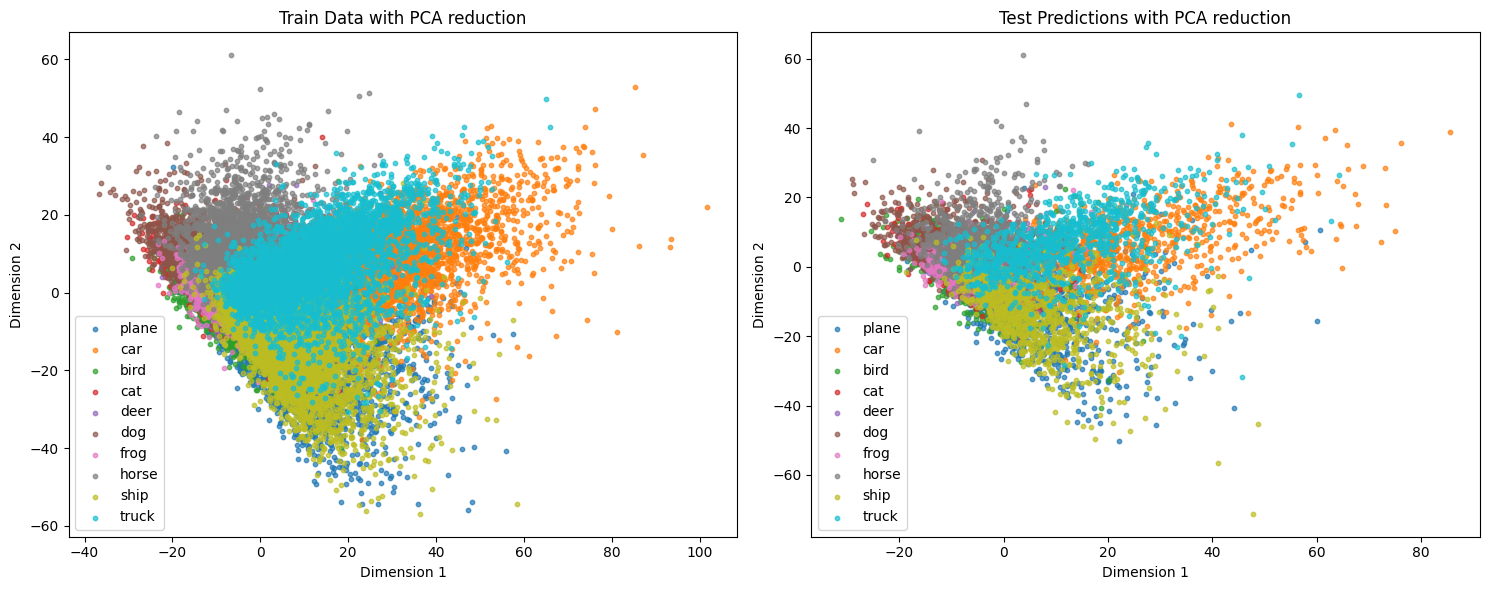

In [53]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plot_PCA(X_train_reduced, classes, 'Train Data with PCA reduction')

plt.subplot(1, 2, 2)
plot_PCA(X_test_reduced, classes, 'Test Predictions with PCA reduction')

plt.tight_layout()
plt.show()

### t-SNE

In [55]:
def plot_tSNE(X, classes, title):
    labels = np.unique(X['label'])
    for label in labels:
        plt.scatter(X[X['label'] == label]['x'],
                    X[X['label'] == label]['y'],
                    label=classes[label], alpha=0.7, s=10)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title(title)
    plt.legend()

In [57]:
tsne = TSNE(n_components=2)
X_train_reduced = tsne.fit_transform(X_train)
X_test_reduced = tsne.fit_transform(X_test)

X_train_reduced = pd.DataFrame(data=X_train_reduced, columns=['x', 'y'])
X_train_reduced['label'] = y_train

X_test_reduced = pd.DataFrame(data=X_test_reduced, columns=['x', 'y'])
X_test_reduced['label'] = y_test
X_test_reduced['pred'] = preds

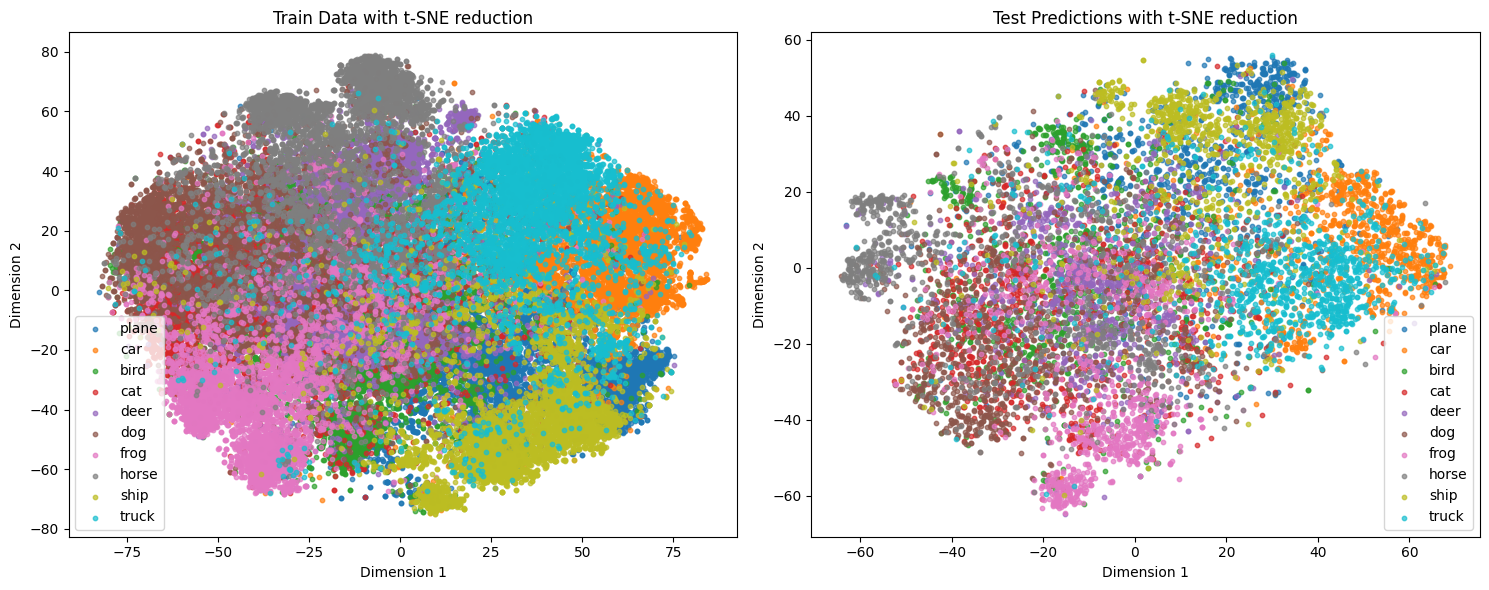

In [58]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plot_tSNE(X_train_reduced, classes, 'Train Data with t-SNE reduction')

plt.subplot(1, 2, 2)
plot_tSNE(X_test_reduced, classes, 'Test Predictions with t-SNE reduction')

plt.tight_layout()
plt.show()

In [49]:
train_embeddings.to_csv('data/train_embeddings.csv', index=False)
test_embeddings.to_csv('data/test_embeddings.csv', index=False)
X_train_reduced.to_csv('data/train_reduced.csv', index=False)
X_test_reduced.to_csv('data/test_reduced.csv', index=False)